# Importing libraries 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2DTranspose, ReLU
import keras
from keras.models import Model as KerasModel
from keras.models import Sequential
from keras.layers import Dense, UpSampling2D, Dropout, Input, Flatten, Reshape, MaxPool2D
from keras.layers.advanced_activations import LeakyReLU, ELU, ReLU
from keras.layers.convolutional import Conv2D

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# setting up dataset directory 
test_dir_color = '/kaggle/input/image-colorization-dataset/data/test_color/'
test_dir_bw = '/kaggle/input/image-colorization-dataset/data/test_black/'


train_dir_color = '/kaggle/input/image-colorization-dataset/data/train_color/'
train_dir_bw = '/kaggle/input/image-colorization-dataset/data/train_black/'

# Visualizing the dataset

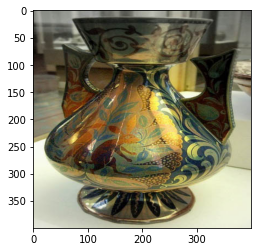

In [3]:
img_file = os.path.join(train_dir_color, os.listdir(train_dir_color)[0] )
img = plt.imread(img_file)
plt.imshow(img)

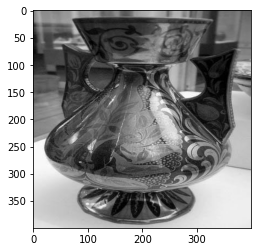

In [4]:
img_file = os.path.join(train_dir_bw, os.listdir(train_dir_bw)[0] )
img = plt.imread(img_file)
plt.imshow(img)

### Converting RGB images to LAB

In [5]:
lab_dir_test = 'LAB_test'
lab_dir_train = 'LAB_train'
image_feature_dir = 'img_feature'
if not os.path.exists(lab_dir_test):
    os.mkdir(lab_dir_test)
if not os.path.exists(lab_dir_train):
    os.mkdir(lab_dir_train)
if not os.path.exists(image_feature_dir):
    os.mkdir(image_feature_dir)

In [6]:
img = cv2.imread(img_file)
img_bw = cv2.imread(img_file, 0)
img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
l,a,b = cv2.split(img_lab)

In [7]:
for img_file in tqdm(os.listdir(train_dir_color)):
    img_path = os.path.join(train_dir_color, img_file)
    img = cv2.imread(img_path)
    lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    outfile_path = os.path.join(lab_dir_train,img_file)
    cv2.imwrite(outfile_path, lab_img)

100%|██████████| 5000/5000 [01:19<00:00, 62.66it/s]


In [8]:
for img_file in tqdm(os.listdir(test_dir_color)):
    img_path = os.path.join(test_dir_color, img_file)
    img = cv2.imread(img_path)
    lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    outfile_path = os.path.join(lab_dir_test,img_file)
#     outfile_path = outfile_path.replace('.jpg', '.lab')
    cv2.imwrite(outfile_path, lab_img)

100%|██████████| 739/739 [00:12<00:00, 60.24it/s]


# Preprocessing the Data

In [9]:
base_model = tf.keras.applications.inception_v3.InceptionV3(include_top=False)
inp = base_model.input
output = base_model.layers[-1].output
feature_extractor = tf.keras.Model(inp, output)

2022-10-08 14:15:12.456600: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 14:15:12.554166: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 14:15:12.555006: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-08 14:15:12.556659: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

87924736/87910968 [==============================] - 0s 0us/step


In [10]:
def preprocess_image(img_path, shape=(299,299), preprocess_fn=tf.keras.applications.inception_v3.preprocess_input):
    img = cv2.imread(img_path)
    lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    l,a, b = cv2.split(lab_img)
    l = cv2.cvtColor(l, cv2.COLOR_GRAY2BGR)
    l = tf.image.resize(l, shape)
    l = preprocess_fn(l)
    return l


In [11]:
def get_image_feature(img_path):
    img = preprocess_image(img_path)
    feature = feature_extractor(np.reshape(img, (-1,299,299,3)))
    base_name  = os.path.basename(img_path).replace('.jpg', '.npy')
    new_path = os.path.join(image_feature_dir, base_name)
    return feature, new_path

In [12]:
for img_file in tqdm(os.listdir(train_dir_color)):
    img_path = os.path.join(train_dir_color,img_file )
    feature, new_path = get_image_feature(img_path)
    np.save(new_path, feature)

100%|██████████| 5000/5000 [07:31<00:00, 11.08it/s]


In [13]:
img_path = os.path.join(train_dir_color, os.listdir(train_dir_color)[0] )
print(img_path)
feature, new_path = get_image_feature(img_path)

/kaggle/input/image-colorization-dataset/data/train_color/image4781.jpg


In [14]:
feature.shape

TensorShape([1, 8, 8, 2048])

### Creating the Dataloader

In [15]:
file_names = [f.split('.')[0] for f in os.listdir('img_feature')[:1000]]
file_names[:10]

['image4428',
 'image1273',
 'image4743',
 'image1628',
 'image2448',
 'image4403',
 'image3374',
 'image4371',
 'image2972',
 'image2829']

In [16]:
tmp = np.load(os.path.join('img_feature', '.'.join(['image2300', 'npy'])))
tmp = tmp.reshape((8,8,2048))
tmp.shape

(8, 8, 2048)

In [17]:
X_train = []
for name in file_names:
    img = np.load(os.path.join('img_feature', '.'.join([name, 'npy'])))
    img =img.reshape((8,8,2048))
    X_train.append(img)
print(len(X_train))

1000


In [18]:
X_train[0].shape

(8, 8, 2048)

In [19]:
Y_train = []
for name in file_names:
    img_path = os.path.join(train_dir_color, '.'.join([name, 'jpg']))
    img = cv2.imread(img_path)
    img = cv2.resize(img, (287,287), interpolation=cv2.INTER_AREA)
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    ab = img_lab[:,:,1:]
    Y_train.append(ab/255) # normalize the output image
len(Y_train)

1000

In [20]:
class ImageColorizationDataset(tf.keras.utils.Sequence):
    def __init__(self, X, y, batch_size=32, shuffle=True):
    
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.X = X
        self.y = y 

        self.on_epoch_end()
    
    
    
    def on_epoch_end(self):
        self.indices = np.arange(len(self.X))
        if self.shuffle:
            np.random.shuffle(self.indices)
      
    def __len__(self):
        return int(np.floor(len(self.X)/self.batch_size))


    def __iter__(self):
        for item in ( self.__getitem__(i) for i in range(len(self))):
            yield item

    def __getitem__(self, index):
        idx = self.indices[ index * self.batch_size : (index +1) * self.batch_size ]
        # ids = [ self.image_ID[idx] for idx in indexes]
        X, y = self._generate_data(idx)
        return (X, y)

    def _generate_data(self, idx):
        x_shape = self.X[idx[0]].shape
        X = np.empty(shape=[self.batch_size, *x_shape])
        y_shape = self.y[idx[0]].shape
        y = np.empty(shape=[self.batch_size, *y_shape])

        for i, id in enumerate(idx):
            X[i] = self.X[id]
            y[i] = self.y[id]

        return X, y

In [21]:
datagen = ImageColorizationDataset(X_train, Y_train, batch_size=2)

# Creating the Model

In [22]:
inputs = tf.keras.Input(shape=(8, 8, 2048))
x = Conv2DTranspose(filters=512,kernel_size=(3,3),strides=(2, 2))(inputs)
x = ReLU()(x)
x = Conv2DTranspose(filters=128,kernel_size=(3,3),strides=(2, 2))(x)
x = ReLU()(x)
x = Conv2DTranspose(filters=64,kernel_size=(3,3),strides=(2, 2))(x)
x = ReLU()(x)
x = Conv2DTranspose(filters=32,kernel_size=(3,3),strides=(2, 2))(x)
x = ReLU()(x)
x = Conv2DTranspose(filters=2,kernel_size=(3,3),strides=(2, 2))(x)
outputs = tf.keras.activations.tanh(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="colorier")
model.compile(optimizer='adam', loss='mean_absolute_error', metrics =['accuracy'])
model.summary()  

Model: "colorier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 8, 8, 2048)]      0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 17, 17, 512)       9437696   
_________________________________________________________________
re_lu (ReLU)                 (None, 17, 17, 512)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 35, 35, 128)       589952    
_________________________________________________________________
re_lu_1 (ReLU)               (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 71, 71, 64)        73792     
_________________________________________________________________
re_lu_2 (ReLU)               (None, 71, 71, 64)        0  

# Training the Model

In [23]:
epochs= 30
history = model.fit(datagen, epochs=epochs)

2022-10-08 14:23:06.496747: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
500/500 [==============================] - 6s 10ms/step - loss: 0.0684 - accuracy: 0.5429
Epoch 2/30
500/500 [==============================] - 5s 11ms/step - loss: 0.0381 - accuracy: 0.5503
Epoch 3/30
500/500 [==============================] - 5s 11ms/step - loss: 0.0370 - accuracy: 0.5653
Epoch 4/30
500/500 [==============================] - 5s 11ms/step - loss: 0.0351 - accuracy: 0.5937
Epoch 5/30
500/500 [==============================] - 5s 11ms/step - loss: 0.0340 - accuracy: 0.6138
Epoch 6/30
500/500 [==============================] - 5s 10ms/step - loss: 0.0334 - accuracy: 0.6260
Epoch 7/30
500/500 [==============================] - 5s 11ms/step - loss: 0.0314 - accuracy: 0.6389
Epoch 8/30
500/500 [==============================] - 5s 10ms/step - loss: 0.0302 - accuracy: 0.6494
Epoch 9/30
500/500 [==============================] - 5s 11ms/step - loss: 0.0289 - accuracy: 0.6565
Epoch 10/30
500/500 [==============================] - 5s 11ms/step - loss: 0.0277 - accura

# Validating the Model

In [24]:
# first pass history
history.history

{'loss': [0.06839366257190704,
  0.038142863661050797,
  0.037013161927461624,
  0.035149041563272476,
  0.03395863249897957,
  0.03339151293039322,
  0.031354568898677826,
  0.030202770605683327,
  0.02893049269914627,
  0.027729889377951622,
  0.026761500164866447,
  0.025870947167277336,
  0.024976251646876335,
  0.024343522265553474,
  0.02370218187570572,
  0.02283981256186962,
  0.022433020174503326,
  0.021922169253230095,
  0.021619265899062157,
  0.02140701189637184,
  0.021058516576886177,
  0.020722195506095886,
  0.020242955535650253,
  0.019940992817282677,
  0.01982448436319828,
  0.019632231444120407,
  0.019638434052467346,
  0.019126001745462418,
  0.018825450912117958,
  0.018487807363271713],
 'accuracy': [0.5429275035858154,
  0.5503369569778442,
  0.5652812123298645,
  0.5936787128448486,
  0.6137721538543701,
  0.6260366439819336,
  0.6389440894126892,
  0.6494150757789612,
  0.6565168499946594,
  0.6673593521118164,
  0.6811628341674805,
  0.6878436207771301,
  0

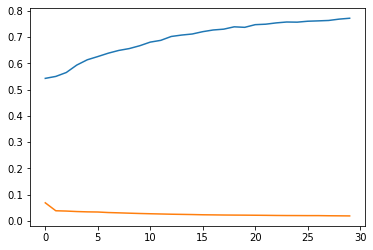

In [25]:
# first passs plotting
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['loss'], label='Loss')

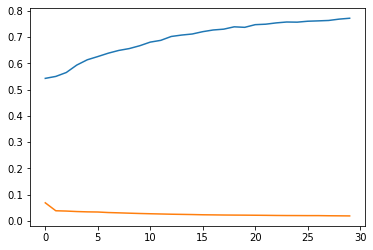

In [26]:
# second passs plotting
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['loss'], label='Loss')

In [27]:
f = os.listdir('img_feature')[900]
f_path_np = os.path.join('img_feature', f) 
f_path_img_color = os.path.join(train_dir_color, f.replace('.npy', '.jpg'))
f_path_img_bw = os.path.join(train_dir_bw, f.replace('.npy', '.jpg'))

### Grayscale Image

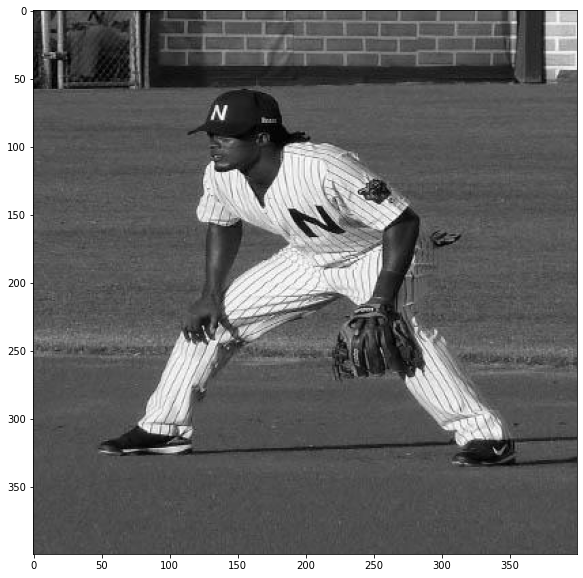

In [28]:
figure = plt.figure(figsize=(10,10))
plt.imshow(plt.imread(f_path_img_bw))

In [29]:
img_feature = np.load(f_path_np)
y_hat = model.predict(img_feature)


input_img = cv2.imread(f_path_img_bw, 0)
input_img = cv2.resize(input_img, (287,287))
input_img = input_img/255
# input_img.shape

final_output = np.zeros(shape=[287,287,3])
final_output[:,:,0] = input_img
final_output[:,:,1:] = y_hat[0]

### Colored Image

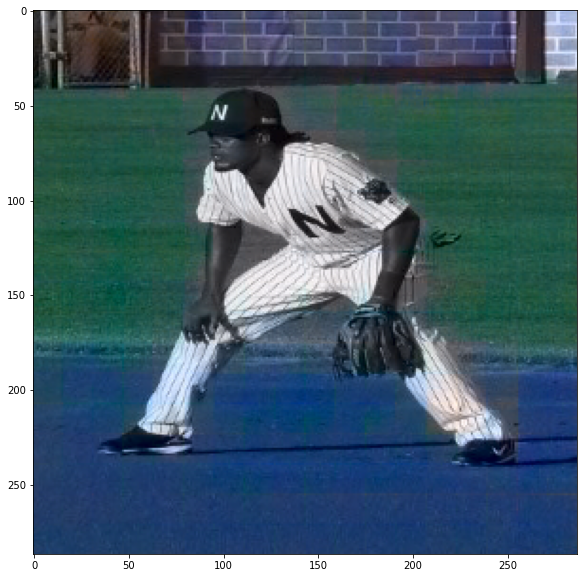

In [30]:
final_output_rbg = cv2.cvtColor((final_output * 255).astype(np.uint8), cv2.COLOR_LAB2BGR)
figure = plt.figure(figsize=(10,10))
plt.imshow(final_output_rbg)

### Original Image

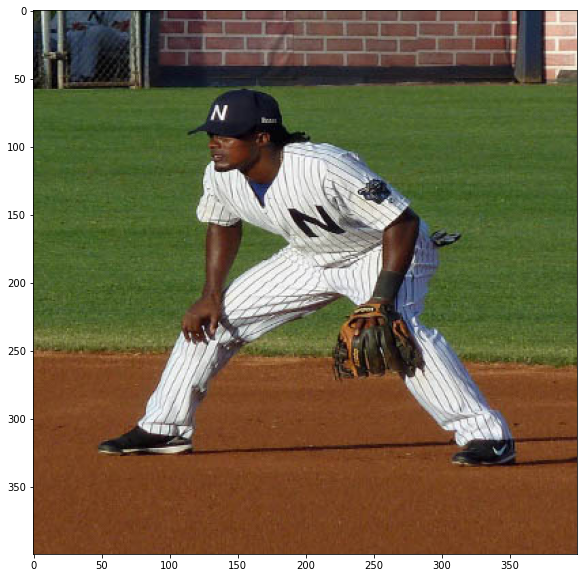

In [31]:
figure = plt.figure(figsize=(10,10))
plt.imshow(plt.imread(f_path_img_color))